# 24.01 Capstone: Supervised Learning

## Dataset Selection

### Dataset of Interest: Census Income Data Set 

- Repository Home: https://archive.ics.uci.edu/ml/datasets/Census+Income
- Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

- Source: 
    - Ronny Kohavi and Barry Becker
    - Data Mining and Visualization
    - Silicon Graphics.
    - e-mail: ronnyk '@' sgi.com for questions.
    
- Data Set Variables:
    - _age_: Age of the individual in the observation.
    - _workclass_: Employment status of the individual in the observation.
    - _fnlwgt_: final weight, the number of people the census believes the entry represents. 
    - _educaiton_: Highest level of education achieved by the individual in the observation.
    - _education_num_: Equivalent grade level
    - _marital_status_: Martial status of the individual in the observation.
    - _occupation_: The occupation of the individual in the observation. 
    - _relationship_: What the individual in the observation is in relation to others.
    - _race_: Census race categories
    - _sex_: Biological sex of the individual in the observation.
    - _capital_gain_: Reported capital gains for the individual in the observation.
    - _capital_loss_: Reported capital loss for the individual in the observation.
    - _hours_per_week_: Reported work hours per week for the individual in the observation.
    - _native_country_: Country of origin for the individual
    - _income_: Identifier for income level

### Outside Resources: 
- [Feature Transformation for Machine Learning, a Beginners Guide](https://medium.com/vickdata/four-feature-types-and-how-to-transform-them-for-machine-learning-8693e1c24e80)
- [Gradient Boosting Decision Tree Algorithm Explained](https://towardsdatascience.com/machine-learning-part-18-boosting-algorithms-gradient-boosting-in-python-ef5ae6965be4)
- [In Depth: Parameter Tuning for SVC](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769)
- [Technical Deep Dive: Random Forests](https://medium.com/panoramic/technical-deep-dive-random-forests-7cf4bbc4c11a)
- [Boosting Algorithms Explained](https://towardsdatascience.com/boosting-algorithms-explained-d38f56ef3f30)

### Imports

In [1]:
import math

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from scipy.stats import percentileofscore
from sklearn import preprocessing

### User Functions

In [2]:
def df_info(dataframe):
    """
    Print out some basic info about the dataframe being passed in.  Print the data types, number of rows and columns, column indexes and names, and the precent null for each column
    """
    print("Data Types:")
    print(dataframe.dtypes)
    print("="*80)
    print(f"Rows: {dataframe.shape[0]} | Columns: {dataframe.shape[1]}")
    print("="*80)
    print("Column Names: ")
    for i, col in enumerate(dataframe.columns):
        print(f"\t{i:>5} {col}")
    print("="*80)
    print("Percent Null")
    print(dataframe.apply(lambda x: sum(x.isnull()) / dataframe.shape[0]))

In [3]:
# Plot a correlaiton matrix
def corr_plot(corr_mat,figsize):
    """
    Pass in a correlation matrix and figsize (as a tuple) and plot the resulting heatmap.
    """
    plt.figure(figsize=figsize)

    sns.heatmap(corr_mat, square=True, annot=True, linewidth=0.5)
    plt.title(f"Correlation matrix of continuous variables")

    # Fix display issues for this version of matplotlib
    b,t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b,t)
    # plt.yticks(rotation=360)

    plt.show();

In [4]:
def winsorized_comparison(df, col, tup):
    """Create a set of box plots comparing un-winsorized variables to winsorized variables.  Take in a dataframe, a column name, and a tuple pair that delinates the lower and upper cuts for winsorization."""
    plt.figure(figsize=(18,6))

    plt.subplot(1,2,1)
    plt.boxplot(df[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of unwinsorized {col}")

    plt.subplot(1,2,2)
    winsorized = winsorize(df[col], tup)
    plt.boxplot(winsorized)
    plt.xticks([1], [f"{col} (winsorized)"])
    plt.title(f"Box Plot of winsorized {col}")

    plt.suptitle(f"Unwinsorized and Winsorized box plots of {col}")
    plt.show()

    q75, q25 = np.percentile(winsorized, [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    outliers = len((np.where((winsorized > max_val) 
                | (winsorized < min_val))[0]))

    pcnt_min = percentileofscore(winsorized, min_val)
    pcnt_max = percentileofscore(winsorized, max_val)
    
    display(f"{col} - IQR Threshold: {1.5:>{4}.1f} | Outliers: {outliers}");

### Data Loading

In [5]:
# Load the dataset, variable names must be defined as they are not included in a header row
df_raw = pd.read_csv("adult.data",sep=",", names=["age","workclass","fnlwgt","education","education_num",
    "marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week",
    "native_country","income"],index_col=False)

In [8]:
# The imported data had leading and trailining spaces in categorical columns, strip them off
for col in df_raw.select_dtypes(include=["object","category"]).columns:
    df_raw[col] = df_raw[col].str.strip()

### Data Basics

In [6]:
# Print out basic info on the dataframe
df_info(df_raw)

Data Types:
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object
Rows: 32561 | Columns: 15
Column Names: 
	    0 age
	    1 workclass
	    2 fnlwgt
	    3 education
	    4 education_num
	    5 marital_status
	    6 occupation
	    7 relationship
	    8 race
	    9 sex
	   10 capital_gain
	   11 capital_loss
	   12 hours_per_week
	   13 native_country
	   14 income
Percent Null
age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education_num     0.0
marital_status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital_gain      0.0
capital_loss      0.0
hours_per_week    0.

In [7]:
# Create a paraent list to hold dataframe elements
parent = list()

# Looking for possible Nominal, Dichotomus, or Ordinal features.  Take a look a unique values
for col in df_raw.columns:
    # Get a count of unique values in the categorical column
    unique_count = df_raw[col].nunique()

    # Append the column name and unique count to the parent list
    parent.append([col,unique_count,df_raw[col].dtype])

# Build a dataframe to display the unique values
column_uniques = pd.DataFrame(parent,columns=["Variable","Unique_Values","Current_Datatype"])

# Display the summary dataframe
column_uniques

Variable  Unique_Values Current_Datatype
0              age             73            int64
1        workclass              9           object
2           fnlwgt          21648            int64
3        education             16           object
4    education_num             16            int64
5   marital_status              7           object
6       occupation             15           object
7     relationship              6           object
8             race              5           object
9              sex              2           object
10    capital_gain            119            int64
11    capital_loss             92            int64
12  hours_per_week             94            int64
13  native_country             42           object
14          income              2           object

## Exploratory Data Analysis (EDA) & Feature Engineering

### EDA
| Variable | Type | 
| :------- | ---: |
| _age_ | Nominal |
| _workclass_ | Nominal | 
| _fnlwgt_ | Continuous | 
| _education_ | Ordinal | 
| _education_num_ | Ordinal |
| _marital_status_ | Nominal |
| _occupation_ | Nominal |
| _relationship_ | Nominal | 
| _race_ | Nominal | 
| _sex_ | Dichotomus | 
| _capital_gain_ | Continuous |
| _capital_loss_ | Continuous | 
| _hours_per_week_   | Condinuous | 
| _native_country_   | Nominal | 
| _income_ | Dichotomus |

In [9]:
# Describe while suppressing scientific notation
pd.set_option("display.float_format", lambda x: f"{x:.5f}")
display(df_raw.describe())
pd.reset_option("display.float_format")

age        fnlwgt  education_num  capital_gain  capital_loss  \
count 32561.00000   32561.00000    32561.00000   32561.00000   32561.00000   
mean     38.58165  189778.36651       10.08068    1077.64884      87.30383   
std      13.64043  105549.97770        2.57272    7385.29208     402.96022   
min      17.00000   12285.00000        1.00000       0.00000       0.00000   
25%      28.00000  117827.00000        9.00000       0.00000       0.00000   
50%      37.00000  178356.00000       10.00000       0.00000       0.00000   
75%      48.00000  237051.00000       12.00000       0.00000       0.00000   
max      90.00000 1484705.00000       16.00000   99999.00000    4356.00000   

       hours_per_week  
count     32561.00000  
mean         40.43746  
std          12.34743  
min           1.00000  
25%          40.00000  
50%          40.00000  
75%          45.00000  
max          99.00000

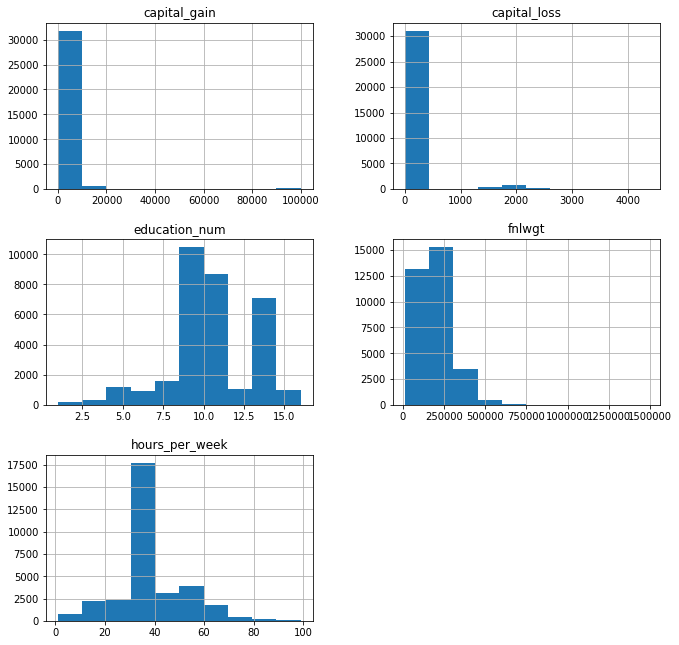

In [10]:
# Take a look at select condinuous columns, exclude age as it will be binned
plt_df = df_raw.select_dtypes(exclude=["object","category"]).iloc[:,1:]

plt_df.hist(figsize=[11,11]);

fnlwgt  education_num  capital_gain  capital_loss  \
fnlwgt          1.000000      -0.043195      0.000432     -0.010252   
education_num  -0.043195       1.000000      0.122630      0.079923   
capital_gain    0.000432       0.122630      1.000000     -0.031615   
capital_loss   -0.010252       0.079923     -0.031615      1.000000   
hours_per_week -0.018768       0.148123      0.078409      0.054256   

                hours_per_week  
fnlwgt               -0.018768  
education_num         0.148123  
capital_gain          0.078409  
capital_loss          0.054256  
hours_per_week        1.000000

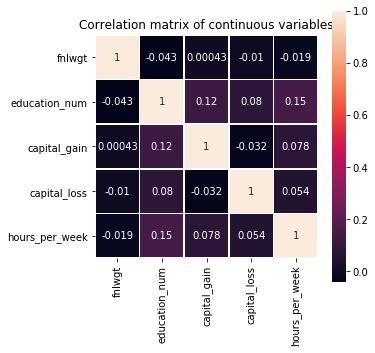

In [11]:
# Take a look at the correlations between continuous variables 
continuous_corr = plt_df.corr()

# Display the correlation table
display(continuous_corr)

# Get a column count to set the figure size 
col_count = len(plt_df.columns)

# Plot the correlation matrix
corr_plot(continuous_corr,(col_count,col_count))

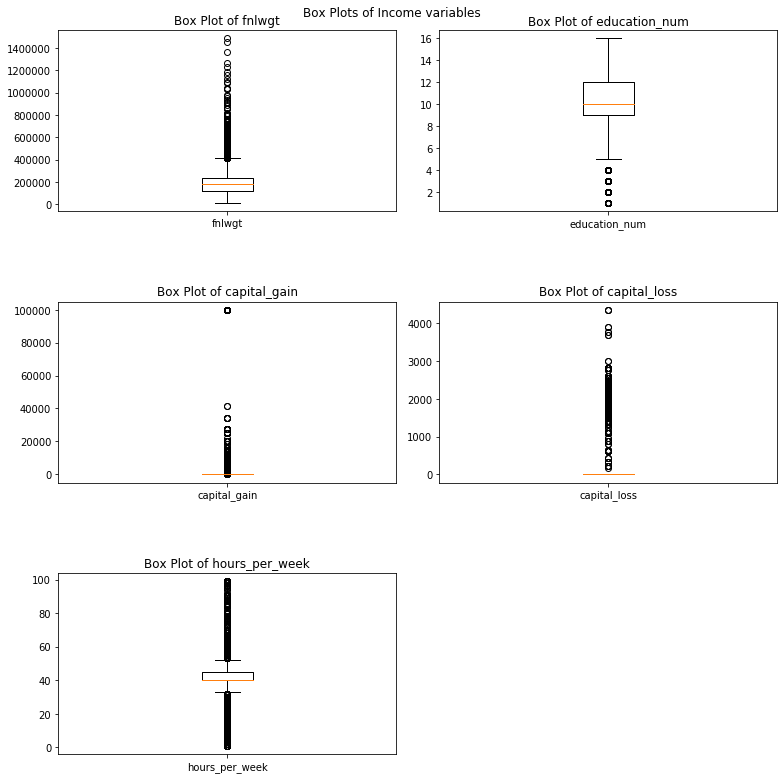

In [12]:
# Take an initial look at the data with box plots to get a feel for outliers
plt.figure(figsize=(11,11))

for i, col in enumerate(plt_df.columns): 
    # col = df_raw.iloc[:, [i]].columns[0]
    plt.subplot(3,2,(i+1))
    plt.boxplot(plt_df[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of {col}")

plt.suptitle("Box Plots of Income variables")
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, top=0.95)

plt.show();

In [13]:
# Select the continuous variables to start looking at outliers

# Determine the first and third quartiles for each variable and return a series
Q1 = plt_df.quantile(0.25)
Q3 = plt_df.quantile(0.75)

# Calculate the Inter Quartile Range for each variable and return a series
IQR = Q3 - Q1

# Get the min and max values for the columns
col_max = plt_df.max()
col_min = plt_df.min()

# Get the 90th and 10th percentiles
ninetyith = plt_df.quantile(0.9) # 90th percentile
ninetyfifth = plt_df.quantile(0.95) # 95th percentile
ninetynineith = plt_df.quantile(0.99) # 99th percentile
tenth = plt_df.quantile(0.1) # 10th percentile
fifth = plt_df.quantile(0.05) # 5th percentile
first = plt_df.quantile(0.01) # 1st percentile

# Bring the calculations together for presentation of the IQR information
iqr_info = pd.concat([col_max,col_min,Q3,Q1,IQR,ninetyith,
    ninetyfifth,ninetynineith,tenth,fifth,first],axis=1).reset_index().rename(columns={
        "index":"variable",0.0:"MAX",1.0:"MIN",0.75:"Q3",0.25:"Q1",
        2.0:"IQR",0.9:"90th",0.95:"95th",0.99:"99th",0.1:"10th",0.05:"5th",0.01:"1st"})
iqr_info

variable      MAX    MIN        Q3        Q1       IQR      90th  \
0          fnlwgt  1484705  12285  237051.0  117827.0  119224.0  329054.0   
1   education_num       16      1      12.0       9.0       3.0      13.0   
2    capital_gain    99999      0       0.0       0.0       0.0       0.0   
3    capital_loss     4356      0       0.0       0.0       0.0       0.0   
4  hours_per_week       99      1      45.0      40.0       5.0      55.0   

       95th      99th     10th      5th      1st  
0  379682.0  510072.0  65716.0  39460.0  27185.8  
1      14.0      16.0      7.0      5.0      3.0  
2    5013.0   15024.0      0.0      0.0      0.0  
3       0.0    1980.0      0.0      0.0      0.0  
4      60.0      80.0     24.0     18.0      8.0

In [14]:
# Construct a matrix to assist in setting the lower an upper cutoff arguments for winsorization
outlier_matrix = list()
for col in plt_df.columns:
    # First percentile
    outliers_1st = np.count_nonzero(
        np.where(plt_df[f"{col}"]) < iqr_info[iqr_info["variable"]==f"{col}"]["1st"].values[0])
    
    # Fifth percentile
    outliers_5th = np.count_nonzero(
        np.where(plt_df[f"{col}"]) < iqr_info[iqr_info["variable"]==f"{col}"]["5th"].values[0])
    
    # Tenth percentile
    outliers_10th = np.count_nonzero(
        np.where(plt_df[f"{col}"]) < iqr_info[iqr_info["variable"]==f"{col}"]["10th"].values[0])
    
    # First quartile
    outliers_q1 = np.count_nonzero(
        np.where(plt_df[f"{col}"]) < iqr_info[iqr_info["variable"]==f"{col}"]["Q1"].values[0])
    
    # Third quartile
    outliers_q3 = np.count_nonzero(
        np.where(plt_df[f"{col}"]) > iqr_info[iqr_info["variable"]==f"{col}"]["Q3"].values[0])
    
    # Ninetyith percentile
    outliers_90th = np.count_nonzero(
        np.where(plt_df[f"{col}"]) > iqr_info[iqr_info["variable"]==f"{col}"]["90th"].values[0])
    
    # Ninety-Fifth percentile
    outliers_95th = np.count_nonzero(
        np.where(plt_df[f"{col}"]) > iqr_info[iqr_info["variable"]==f"{col}"]["95th"].values[0]) 
    
    # Ninety-Nineth percentile
    outliers_99th = np.count_nonzero(
        np.where(plt_df[f"{col}"]) > iqr_info[iqr_info["variable"]==f"{col}"]["99th"].values[0])
    
    # Append the percentiles and quartiles to the outlier_matrix list
    outlier_matrix.append([col,outliers_1st,outliers_5th,outliers_10th,outliers_q1,
        outliers_q3,outliers_90th,outliers_95th,outliers_99th,])

# Convert the outlier matrix into a dataframe that contains both percentiles and quartiles ie x_tiles
x_tile_values = pd.DataFrame(outlier_matrix).rename(columns={0:"variable",1:"1st_(0.01)",2:"5th_(0.05)",3:"10th_(0.10)",4:"Q1",5:"Q3",6:"90th_(0.90)",7:"95th_(0.95)",8:"99th_(0.99)"})

# Display the x_tiles dataframe
x_tile_values

variable  1st_(0.01)  5th_(0.05)  10th_(0.10)     Q1     Q3  \
0          fnlwgt       27186       32561        32561  32561      0   
1   education_num           3           5            7      9  32548   
2    capital_gain           0           0            0      0   2711   
3    capital_loss           0           0            0      0   1519   
4  hours_per_week           8          18           24     40  32515   

   90th_(0.90)  95th_(0.95)  99th_(0.99)  
0            0            0            0  
1        32547        32546        32544  
2         2711         2288         1473  
3         1519         1519         1419  
4        32505        32500        32480

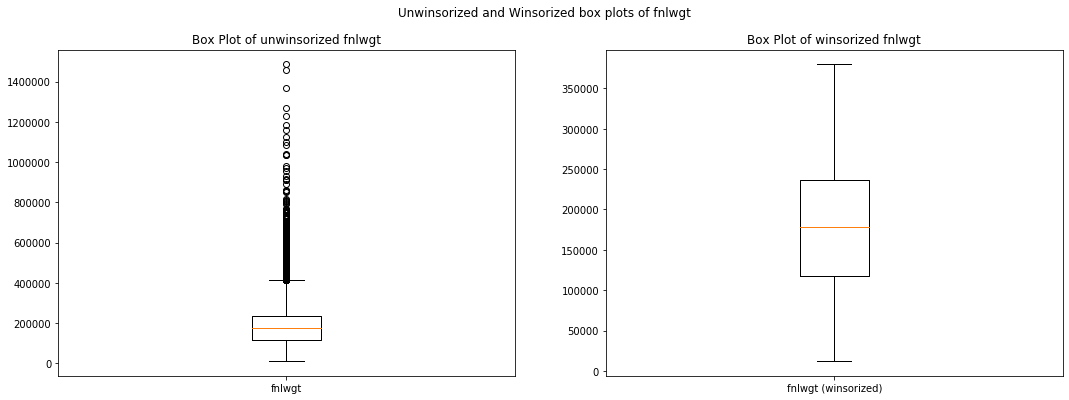

'fnlwgt - IQR Threshold:  1.5 | Outliers: 0'

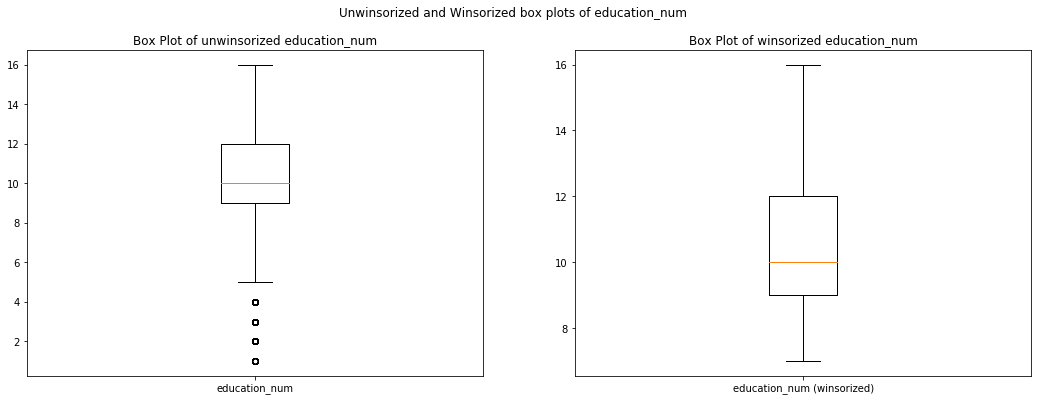

'education_num - IQR Threshold:  1.5 | Outliers: 0'

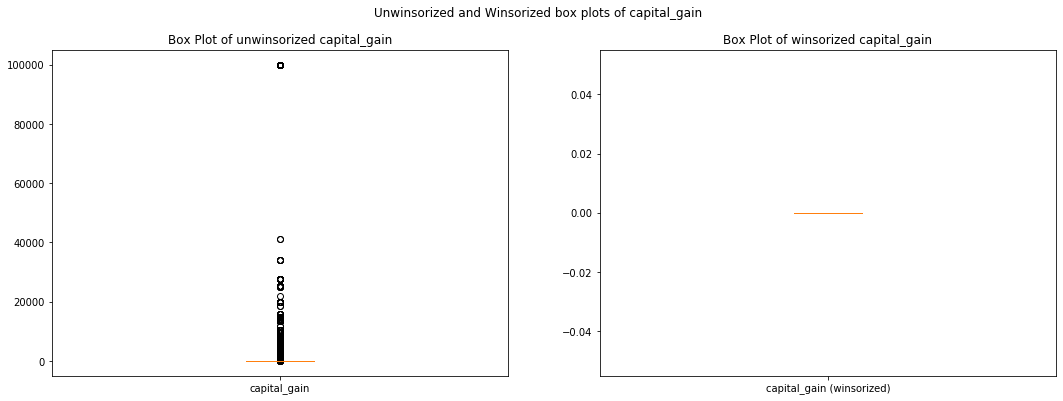

'capital_gain - IQR Threshold:  1.5 | Outliers: 0'

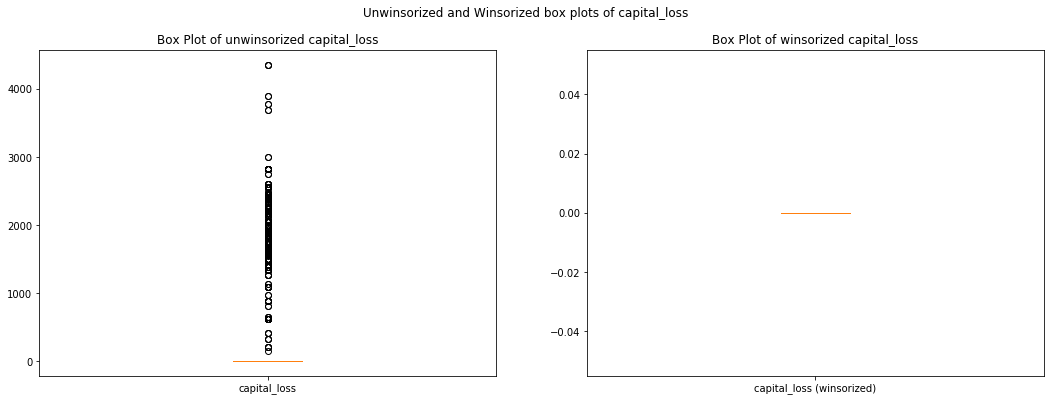

'capital_loss - IQR Threshold:  1.5 | Outliers: 0'

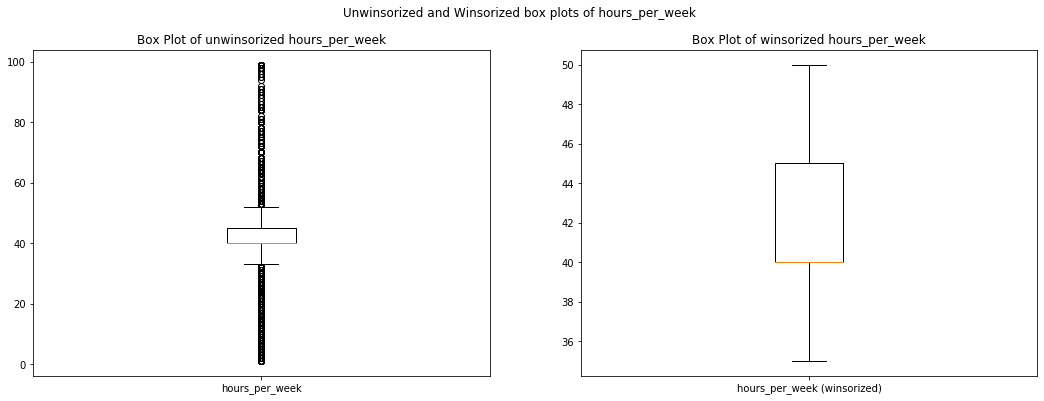

'hours_per_week - IQR Threshold:  1.5 | Outliers: 0'

In [15]:
# Create a dict to store columns and winsorization cutoff values
winsorize_vals = dict(
    fnlwgt=(0.00,0.05),
    education_num=(0.10,0.01),
    capital_gain=(0.00,0.10),
    capital_loss=(0.00,0.05),
    hours_per_week=(0.20,0.15)
)

# Plot the winsorized values for comparison sake and see if your missing any outliers 
for i, (k,v) in enumerate(winsorize_vals.items()):
    # print(f"index: {i}, key: {k}, value: {v}")
    winsorized_comparison(plt_df,k,v)

In [16]:
# Now that the outliers have been handled, join new winsorized columns to the life_expectancy_df dataframe
df_winsorized = df_raw.copy()

# Loop over the columns in the winsorize_vals dict and add columns to the df_winsorized dataframe
for i, (k,v) in enumerate(winsorize_vals.items()):
    # Add a winsorized column to the dataframe
    df_winsorized[f"{k}_winsorized"] = winsorize(df_winsorized[k], v)

# Take a look at the new dataframe and verify the new columns
df_winsorized.iloc[:,-5:].sample(n=3).T

19753   8492    30683
fnlwgt_winsorized          295589  246974  347653
education_num_winsorized       13      11      15
capital_gain_winsorized         0       0       0
capital_loss_winsorized         0       0       0
hours_per_week_winsorized      50      40      50

### Feature Engineering

In [17]:
# Bin the age column

# Define the bins
bins = [10,20,30,40,50,60,70,80]

# Assign bin names
group_names = ["<30","30-39","40-49","50-59","60-69","70-79","80+"]

# Create the bins
age_categories = pd.cut(df_winsorized["age"], bins, labels=group_names)

# Append the new bins to to the dataframe
df_winsorized["age_categories"] = pd.cut(df_winsorized["age"], bins, labels=group_names)

# Now, move the new column to a sensible location 
# Get a list of column names so you can move the appended column to a new index
columns = list(df_winsorized.columns)

# Move the new categorical column to list index # 1
columns.insert(1,columns.pop(20))

# Rearange the dataframe columns
df_winsorized = df_winsorized[columns]

# Take a look at the counts in each bin
pd.value_counts(df_winsorized["age_categories"])

40-49    8546
30-39    8162
50-59    6983
60-69    4128
<30      2410
70-79    1792
80+       441
Name: age_categories, dtype: int64

In [20]:
# Loop over the categorical columns and create dummy columns
for i, col in enumerate(df_winsorized.select_dtypes(include=["object","category"]).columns[:-1]):
    # Add dummy columns to the dataframe
    df_winsorized = pd.concat([
        df_winsorized, 
        pd.get_dummies(df_winsorized[col], prefix=col, drop_first=True)
    ], axis=1)

## Modeling

In [21]:
list(df_winsorized.columns)

['age',
 'age_categories',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income',
 'fnlwgt_winsorized',
 'education_num_winsorized',
 'capital_gain_winsorized',
 'capital_loss_winsorized',
 'hours_per_week_winsorized',
 'age_categories_30-39',
 'age_categories_40-49',
 'age_categories_50-59',
 'age_categories_60-69',
 'age_categories_70-79',
 'age_categories_80+',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'education_11th',
 'education_12th',
 'education_1st-4th',
 'education_5th-6th',
 'education_7th-8th',
 'education_9th',
 'education_Assoc-acdm',
 'education_Assoc-voc',
 'education_Bachelors',
 'education_Doctorate',
 'education_HS-grad',
 'education_Masters',
 'educatio

In [26]:
# Get a list of column names so you can move the appended column to a new index
columns = list(df_winsorized.columns)
# Move the new categorical column to list index # 1
columns.insert(1,columns.pop(20))

df_winsorized = df_winsorized[columns]

df_winsorized.columns

Index(['age', 'age_categories', 'workclass', 'fnlwgt', 'education',
       'education_num', 'marital_status', 'occupation', 'relationship', 'race',
       'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
       'native_country', 'income', 'fnlwgt_winsorized',
       'education_num_winsorized', 'capital_gain_winsorized',
       'capital_loss_winsorized', 'hours_per_week_winsorized'],
      dtype='object')

In [30]:
df_winsorized.columns.get_loc("income")

15

In [24]:
df_winsorized.select_dtypes(exclude=["object","category"]).columns[:11]

Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'fnlwgt_winsorized', 'education_num_winsorized',
       'capital_gain_winsorized', 'capital_loss_winsorized',
       'hours_per_week_winsorized'],
      dtype='object')

In [25]:
X = df_winsorized["age"]
y = df_winsorized["income"]

In [ ]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
